#### Across all scales (experiments), use the union of independent features after controlling for batch parameters and tumour volume. If a feature repeats in multiple scales, use the median of the features

#### For even elements, the median is the average of the middle numbers after sorting in ascending order, for odd number of elements, the median is the element in the middle after sorting it in ascending order

#### To form the graph Laplacian, try multiple approaches:
#### 1. Estimate the graph Laplacian using LASSO, GLASSO, using GMRF assumptions etc
#### 2. Use the Minimum Spanning Tree after eliminating the correlated features

In [1]:
import os
import pandas as pd
import numpy as np

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
import networkx as nx
import pygsp

In [4]:
cd '/home/raghuram/Desktop/radiomics/TEXTURES/results'

/home/raghuram/Desktop/radiomics/TEXTURES/results


In [5]:
home = '/home/raghuram/Desktop/radiomics/TEXTURES/results'

In [6]:
features_folder = '/home/raghuram/Desktop/radiomics/TEXTURES'

In [7]:
folder_list = os.listdir(os.getcwd())

In [8]:
csv_file_dict = {}

In [21]:
def get_csv_files():
    for folder in folder_list:
        if folder[-3:] == 'csv':
            continue
        csv_file_list = sorted(os.listdir(os.path.join(home, folder, 'linear_regression', 'without_idh1')), key=lambda x: int(x.split('_')[0]))
        csv_file_dict[folder] = csv_file_list
    
    return csv_file_dict

In [22]:
modality_csv_files = get_csv_files()

In [23]:
df = pd.read_csv(os.path.join(home, 't2f', 'linear_regression', 'without_idh1', modality_csv_files['t2f'][0]))

In [24]:
features = list(df['response_variable'].unique())

In [25]:
alpha = 0.05
m = len(features)*5
bonferroni_correction_factor = alpha/(m)

In [26]:
def get_all_independent_features_modality(modality, modality_csv_files):
    csv_file_list = modality_csv_files[modality]
    return csv_file_list

In [27]:
csv_file_list = get_all_independent_features_modality('t2f', modality_csv_files)

In [33]:
def filter_relevant_features():
    results_dict = {}
    for modality in modality_csv_files.keys():
        results_dict[modality] = {}
        
        csv_file_list = modality_csv_files[modality]
        for csv_file in csv_file_list:
            df = pd.read_csv(os.path.join(home, modality, 'linear_regression', 'without_idh1', csv_file))
            experiment_number = csv_file.split('_')[0]   
            results_dict[modality][experiment_number] = ['IDH1', '1p_19q_co_del_status']
            for idx, feature in enumerate(features):
                feature_df = df[df['response_variable'] == feature]
    #             print(feature_df.head())
                if np.all(feature_df['pvals']>bonferroni_correction_factor):
                    results_dict[modality][experiment_number].append(feature)
                    continue
                else:
                    continue
    return results_dict

In [34]:
results_dict = filter_relevant_features()

In [35]:
reverse_feature_dict = {}
modality_list =  ['t2w', 't1w', 't1ce', 't2f']
feature_set = {}
for modality in modality_list:
    feature_set[modality] = set()
    reverse_feature_dict[modality] = {}
    for results in results_dict[modality]:
        for feature in results_dict[modality][results]:
            

            if feature not in reverse_feature_dict[modality].keys():
                reverse_feature_dict[modality][feature] = []
            reverse_feature_dict[modality][feature].append(int(results))

In [37]:
for modality, value in reverse_feature_dict.items():
    modality_features_df = pd.read_csv(os.path.join(features_folder, 'expt'+'_'+modality+'.csv'))

    feature_dict = {}
    for feature, expt_list in value.items():
        feature_dict[feature] = np.median(expt_list)
    
    df_features = {}
    df = pd.DataFrame(feature_dict, index=[0])
    df = df.T
    for idx, column in enumerate(df.index):
        expt_number = (df.loc[column,:].item())
        if expt_number.is_integer():
            df_features[column] = np.array(modality_features_df[(modality_features_df['experiment_number'] == expt_number)][column])
        else:
            subset_features_df_1 = modality_features_df[(modality_features_df['experiment_number'] == int(expt_number))][column]
                                                     
            subset_features_df_2 = modality_features_df[(modality_features_df['experiment_number'] == int(expt_number)+1)][column]
            average_df = np.array(subset_features_df_1)/2+np.array(subset_features_df_2)/2
            df_features[column] = average_df
    # Write this dataframe to file
    pd.DataFrame.from_dict(df_features).to_csv(modality+'_'+'features.csv', index=False)


In [57]:
# Estimate the graph Laplacian using GLASSO
from sklearn.covariance import graphical_lasso, GraphicalLassoCV

In [39]:
# Load the dataframe
def load_features(modality_dataframe):
    df = pd.read_csv(modality_dataframe)
    return df

In [127]:
def check_for_positive_semidefinite(K):
    return np.all(np.linalg.eigvals(K)>=0)

In [158]:
def compute_graph_fourier_transform(laplacian_matrix):
    # The Laplacian is symmetric
    eigvalues, eigvectors = np.linalg.eigh(laplacian_matrix)
    return eigvalues, eigvectors

In [173]:
def compute_graph_frequency(eigvectors, graph_signal_matrix, to_filter=False, which_filter=None):
#     if to_filter is None:
    return np.dot(eigvectors.T, graph_signal_matrix.T).T

In [123]:
from sklearn.model_selection import StratifiedKFold

In [133]:
from sklearn.linear_model import LogisticRegression

In [136]:
import csv

In [155]:
from sklearn import covariance

In [137]:
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score

In [175]:
def compute_metrics(y_predicted, y_actual):
    output_dict = {}
    output_dict['acc'] = accuracy_score(y_actual, y_predicted)
    output_dict['roc_score'] = roc_auc_score(y_actual, y_predicted)
    output_dict['precision'] = precision_score(y_actual, y_predicted)
    output_dict['recall'] = recall_score(y_actual, y_predicted)
    output_dict['f1'] = f1_score(y_actual, y_predicted)
    
    return output_dict
    

In [190]:
for modality in modality_list:
    if modality == 't1ce':
        lr_iter = 5000
    else:
        lr_iter = 1000
    modality_laplacian_dict = {}
    filename = modality+'_features.csv'
    df = load_features(filename)
    y = np.array(df['IDH1'])
    df.drop(columns=['IDH1', '1p_19q_co_del_status'], inplace=True)
    X = np.array(df)
    print('Total size: {}'.format(X.shape))
    print('Classwise split in data: {}'.format(y.sum()))
    with open(modality+'_results.csv', 'w') as csvfile:
        fieldnames = ['idx','sparsity_factor_laplacian', 'glasso_iter', 'classifier', 'train_size',
                     'test_size', 'test_auc', 'test_accuracy', 'test_precision', 'test_recall', 'test_f1_score', 
                     'train_auc', 'train_accuracy', 'train_precision', 'train_recall', 'train_f1_score']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        
        skf = StratifiedKFold(n_splits=3, shuffle=False, random_state=42)
        iteration_count = 0
        for train_index, test_index in skf.split(X, y):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            
#             print('Iteration count: {}'.format(iteration_count))
#             print('Test size: {}'.format(X_test.shape))
            print('Train size: {}'.format(X_train.shape))
#             print('Classwise samples in test: {}'.format(y_test.sum()))
#             print('Classwise samples in train: {}'.format(y_train.sum()))
            
#             print('Y_train is {}'.format(y_train))
#             print('Y_test is {}'.format(y_test))

            scaler = StandardScaler()

            scaler.fit_transform(X_train)
            scaler.transform(X_test)
                
            emp_cov = covariance.empirical_covariance(X_train, assume_centered=True)
            shrunk_cov = covariance.shrunk_covariance(emp_cov, shrinkage=0.01)
            
            alpha = 0.02
            max_iter = 100
            _, precision_matrix = graphical_lasso(shrunk_cov, alpha=alpha, max_iter=max_iter)
            # Eliminate self-loops
            np.fill_diagonal(precision_matrix, 0)
            G = nx.from_numpy_array(precision_matrix)
            #Obtain the estimated Laplacian matrix of the graph
            L_hat = nx.laplacian_matrix(G)

            if not check_for_positive_semidefinite(L_hat.todense()):
                print('Laplacian is not positive semi-definite')
                eta = -1*np.min(np.linalg.eigvals(L_hat.todense()))
                L_prime = L_hat.todense()+eta*np.eye(L_hat.todense().shape[0], L_hat.todense().shape[0])

            elif check_for_positive_semidefinite(L_hat.todense()):
                print('The Laplacian is positive semi-definite')
                L_prime = L_hat

            modality_laplacian_dict[iteration_count] = L_prime
            eigvalues, eigvectors = compute_graph_fourier_transform(L_prime)

            # Project the graph signal onto the Fourier basis
            # The train graph signal is X_train, and the test graph signal is X_test

            fourier_train = compute_graph_frequency(eigvectors, X_train)
            print('Fourier train: {}'.format(fourier_train.shape))
            fourier_test = compute_graph_frequency(eigvectors, X_test)

            # Train the classifier on fourier_train. Classify on fourier_test
            clf = LogisticRegression(random_state=42, solver='lbfgs', max_iter=lr_iter,n_jobs=-1).fit(fourier_train, y_train)
            predictions = clf.predict(fourier_test)
            test_metrics = compute_metrics(predictions, y_test)
            train_preds = clf.predict(fourier_train)
            train_metrics = compute_metrics(train_preds, y_train)
            
            writer.writerow({'idx':iteration_count,'sparsity_factor_laplacian':alpha, 'glasso_iter':max_iter, 'classifier':'LR', 
                             'train_size':X_train.shape[0], 'test_size':X_test.shape[0], 
                             'test_auc':test_metrics['roc_score'], 'test_accuracy':test_metrics['acc'], 
                             'test_precision':test_metrics['precision'], 'test_recall':test_metrics['recall'], 
                             'test_f1_score':test_metrics['f1'],
                             'train_auc':train_metrics['roc_score'], 'train_accuracy':train_metrics['acc'], 
                             'train_precision':train_metrics['precision'], 'train_recall':train_metrics['recall'], 
                             'train_f1_score':test_metrics['f1']})
            iteration_count += 1
        
        

Total size: (102, 18)
Classwise split in data: 75
Train size: (68, 18)
Laplacian is not positive semi-definite
Fourier train: (68, 18)
Train size: (68, 18)
Laplacian is not positive semi-definite
Fourier train: (68, 18)
Train size: (68, 18)
Laplacian is not positive semi-definite
Fourier train: (68, 18)
Total size: (99, 24)
Classwise split in data: 72
Train size: (66, 24)
Laplacian is not positive semi-definite
Fourier train: (66, 24)
Train size: (66, 24)
Laplacian is not positive semi-definite
Fourier train: (66, 24)
Train size: (66, 24)
Laplacian is not positive semi-definite
Fourier train: (66, 24)
Total size: (75, 37)
Classwise split in data: 56.0
Train size: (49, 37)
Laplacian is not positive semi-definite
Fourier train: (49, 37)
Train size: (50, 37)
Laplacian is not positive semi-definite
Fourier train: (50, 37)
Train size: (51, 37)
Laplacian is not positive semi-definite
Fourier train: (51, 37)
Total size: (77, 22)
Classwise split in data: 56.0
Train size: (51, 22)
Laplacian is 

In [185]:
LogisticRegression?

In [ ]:
y = np.array(df['IDH1'])
df.drop(columns=['IDH1', '1p_19q_co_del_status'], inplace=True)

In [125]:
y.sum()

72

In [43]:
print('The shape of X is {}'.format(X.shape))

The shape of X is (99, 24)


In [44]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [45]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [47]:
W = np.linalg.inv(np.cov(X, rowvar=False))

In [49]:
# Check for symmetry
assert((np.all(W) == np.all(W.T)))

# Graph is undirected

In [126]:
graphical_lasso?

In [50]:
cov_matrix, precision_matrix = graphical_lasso(np.cov(X.T), alpha=0.02, max_iter=100)

In [58]:
# We don't want any self loops for any node
# Though it will be a good question to ask what is the effect of the self loop?
np.fill_diagonal(precision_matrix, 0)

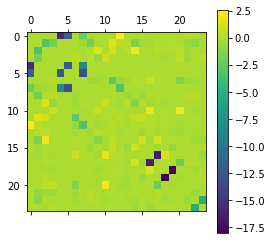

In [63]:
# Display the estimated precision matrix
plt.matshow(precision_matrix)
plt.colorbar()

In [90]:
# Obtain the Laplacian of the graph determined by W above
G = nx.from_numpy_array(precision_matrix)
D = nx.degree(G)
L = nx.laplacian_matrix(G)

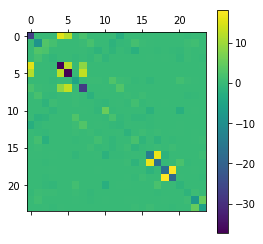

In [91]:
plt.matshow(L.todense())
plt.colorbar()

In [92]:
L.shape

(24, 24)

In [93]:
# As can be seen above there are negative elements in the graph Laplacian 
# We can confirm that it is not positive semi definite

lambda_vals = np.linalg.eigvals(L.todense())
lambda_vals

array([-4.95903854e+01, -5.02438324e+01, -3.58966690e+01, -2.89597274e+01,
       -3.19473709e+01, -1.21354233e+01, -1.02989909e+01,  6.90103783e+00,
       -6.49219845e+00,  5.47059192e+00,  3.73959636e+00,  1.94439999e+00,
        1.39071418e+00, -2.43243189e+00, -2.32297986e+00, -2.00218683e+00,
       -1.70984485e+00, -1.25617785e+00, -9.56279372e-01,  3.49538021e-01,
       -4.20074773e-01, -2.05371723e-01,  4.06397135e-02, -3.24792477e-16])

In [94]:
delta = -1*min(lambda_vals)*np.eye(24,24)

In [103]:
L_prime = L.todense()+delta

In [104]:
np.sort(np.linalg.eigvals(L_prime))

array([2.21225815e-13, 6.53446986e-01, 1.43471634e+01, 1.82964615e+01,
       2.12841050e+01, 3.81084091e+01, 3.99448415e+01, 4.37516339e+01,
       4.78114005e+01, 4.79208525e+01, 4.82416455e+01, 4.85339875e+01,
       4.89876545e+01, 4.92875530e+01, 4.98237576e+01, 5.00384607e+01,
       5.02438324e+01, 5.02844721e+01, 5.05933704e+01, 5.16345466e+01,
       5.21882324e+01, 5.39834287e+01, 5.57144243e+01, 5.71448702e+01])

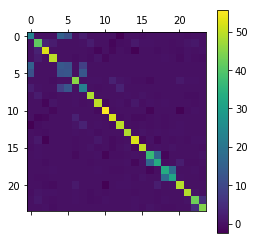

In [105]:
plt.matshow(L_prime)
plt.colorbar()

In [114]:
# For the obtained L_prime, use the signals to obtain the GFT
eigvals, eigvector = np.linalg.eigh(L_prime)

In [115]:
eigvals

array([2.28371862e-13, 6.53446986e-01, 1.43471634e+01, 1.82964615e+01,
       2.12841050e+01, 3.81084091e+01, 3.99448415e+01, 4.37516339e+01,
       4.78114005e+01, 4.79208525e+01, 4.82416455e+01, 4.85339875e+01,
       4.89876545e+01, 4.92875530e+01, 4.98237576e+01, 5.00384607e+01,
       5.02438324e+01, 5.02844721e+01, 5.05933704e+01, 5.16345466e+01,
       5.21882324e+01, 5.39834287e+01, 5.57144243e+01, 5.71448702e+01])

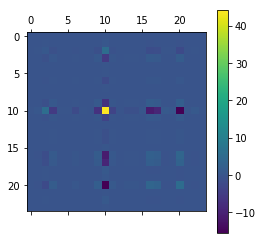

In [108]:
check_for_positive_semidefinite(L_prime)

True

In [ ]:
W = prec_

In [ ]:
import networkx as nx

In [ ]:
G = nx.from_numpy_array(W)

In [ ]:
L = nx.degree(G)

In [ ]:
L

In [ ]:
A, B = graphical_lasso(C, 10, max_iter=1000)

In [ ]:
B

In [ ]:
def get_features_to_exclude(df):
    K = np.array(df.corr())
    x, y = np.where(np.abs(K)>=0.7)
    correlated_pair = []
    drop_columns = []
    for value in zip(x,y):
        if value[0] == value[1]:
            continue
        if (value[1], value[0]) in correlated_pair:
            continue
        correlated_pair.append(value)
        drop_columns.append(value[1])
    
    return drop_columns, correlated_pair

In [ ]:
def drop_correlated_features(df, drop_columns):
    dropped_feature_names = []
    for index in drop_columns:
        dropped_feature_names.append(df.columns[index])
    dropped_df = df.drop(columns=dropped_feature_names, inplace=False)
    return dropped_df

In [ ]:
def form_minimum_spanning_tree(filtered_df):
    A = np.array(filtered_df.corr())
    G = nx.from_numpy_matrix(A)
    # From this graph form the minimum spanning tree
    K = nx.minimum_spanning_tree(G)
    
    return K

In [ ]:
# Normalize the features within group to have unit norm
# Use five-fold cross-validation to see if the results make sense
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [ ]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

In [ ]:
kfold = StratifiedKFold(n_splits=3, random_state=2019)
# classifier = SVC(kernel='rbf', probability=True,
#                    random_state=2019)
classifier = LogisticRegression(random_state=2019)

In [ ]:
from sklearn.utils import shuffle

In [ ]:
prediction_results_df = {}
prediction_results_normalized_df = {}
prediction_results_with_tv = {}

In [ ]:
modality_list = ['t2f']

In [ ]:
def save_plot(modality, fname, signal):
    plt.clf()
    plt.stem(np.linspace(1, signal.shape[0], num=signal.shape[0]), signal.T)
    plt.xlabel('Node index')
    plt.ylabel('Average graph signal for IDH-non-mut in the vertex domain.' )
    plt.savefig(os.path.join(features_folder, 'graph_fourier_transform', modality, fname))

In [ ]:
from pygsp import plotting            

In [ ]:
def form_graph(graph_signal):
        A = np.array(filtered_df.corr())
        B = nx.from_numpy_matrix(A)
        # From this graph form the minimum spanning tree
        M = nx.minimum_spanning_tree(B)
        
        # Obtain the adjacency matrix of the minimum spanning tree
        K = np.abs(nx.adjacency_matrix(B))
        
        G = pygsp.graphs.Graph(K.todense())
        return G

In [ ]:
def normalize_signal(graph_signal):
    scaler = StandardScaler()
    return scaler.fit_transform(graph_signal)
    

In [ ]:
def graph_fourier_bases(G):
    G.compute_fourier_basis()
    U, e = G.U, G.e
    
    return U, e

In [ ]:
def compute_graph_gft(U, graph_signal):
    XG =  np.matmul(np.linalg.inv(U), graph_signal)
    return XG.T

In [ ]:
def compute_graph_tv(G, graph_signal):
    tv = []
    G.compute_fourier_basis()
    L = G.L.todense()
    for idx, signal in enumerate(graph_signal):
        
        tv.append(np.dot(np.dot(signal.T, L), signal))
    
    return np.array(tv)
        

In [ ]:
# Reference: Design of graph filters and filterbanks
def graph_filter(U, A, filter_type):
    
    if filter_type == 'low_pass':
        h = [1 if idx<=int((A.shape[0]-1)/2) else 0 for idx in range(0, A.shape[0])]

    elif filter_type == 'high_pass':
        h = [1 if idx>=int((A.shape[0]-1)/2)else 0 for idx in range(0, A.shape[0])]

    I = np.identity(A.shape[0])
    h_lambda = np.diag(np.matmul(h, I))
    H = np.matmul(np.matmul(U, h_lambda),np.linalg.inv(U))
    return H

In [ ]:
def classification_results(results_dict):
    for modality in ['t2f', 't1w', 't1ce', 't2w']:
        results_dict[modality]= {}
        for experiment_number in range(1,26):
            results_dict[modality][experiment_number] = {}
            df = load_relevant_features(modality, experiment_number)
            codel_labels = df['1p_19q_co_del_status']
            idh_labels = df['IDH1']
            idh_labels = np.array(idh_labels)
            df.drop(columns=['IDH1', '1p_19q_co_del_status'], inplace=True)

            drop_columns, correlated_pair = get_features_to_exclude(df)
            filtered_df = drop_correlated_features(df, drop_columns)

            M = form_minimum_spanning_tree(filtered_df)
            A = np.abs(nx.adj_matrix(M)).todense()
#             if A.shape[0] < 7:
#                 print('Experiment number {} not considered'.format(experiment_number))
#                 continue

            G = pygsp.graphs.Graph(A)
            G.compute_fourier_basis()
            U, _ = graph_fourier_bases(G)

            X = normalize_signal(filtered_df)
            X_normalized_graph = compute_graph_gft(U, X.T)
            total_variation = compute_graph_tv(G, X)  
            
            X_tv = np.hstack((X, np.reshape(total_variation, (total_variation.shape[0], 1))))
            H = graph_filter(U, A, filter_type='high_pass') 
            # Fourier domain signal after filtering
            Y_normalized_graph = np.matmul(np.matmul(H, np.linalg.inv(U)), X.T)

            # Inverse GFT of the filtered signal
            Y = np.matmul(U, Y_normalized_graph)
            tv_filtered = compute_graph_tv(G, Y.T)
            Y_normalized_graph_tv = np.hstack((Y_normalized_graph.T, np.reshape(tv_filtered, (tv_filtered.shape[0], 1))))
            X_normalized_graph_tv = np.hstack((X_normalized_graph, np.reshape(total_variation, (total_variation.shape[0], 1))))
            Y_tv = np.hstack((Y.T, np.reshape(tv_filtered, (tv_filtered.shape[0], 1))))
            
            X, idh_labels = shuffle(Y_normalized_graph.T, idh_labels, random_state=2019)

            train_accuracy = []
            test_accuracy = []
            test_precision = []
            test_recall = []
            test_auc = []
            train_auc = []
            for index, (train, test) in enumerate(kfold.split(X, idh_labels)):
                classifier.fit(X[train], idh_labels[train])
                train_accuracy.append(accuracy_score(idh_labels[train], classifier.predict(X[train])))
                test_accuracy.append(accuracy_score(idh_labels[test], classifier.predict(X[test])))
                test_recall.append(recall_score(idh_labels[test], classifier.predict(X[test])))
                test_precision.append(precision_score(idh_labels[test], classifier.predict(X[test])))
                train_auc.append(roc_auc_score(idh_labels[train], classifier.predict(X[train])))
                test_auc.append(roc_auc_score(idh_labels[test], classifier.predict(X[test])))

            results_dict[modality][experiment_number]['features'] = list(filtered_df.columns)
            results_dict[modality][experiment_number]['aucroc'] = [np.mean(np.array(test_auc)), 
                                                                  np.std(np.array(test_auc))]
            results_dict[modality][experiment_number]['accuracy'] = [np.mean(np.array(test_accuracy)), 
                                                                  np.std(np.array(test_accuracy))]
            results_dict[modality][experiment_number]['precision'] = [np.mean(np.array(test_precision)), 
                                                                  np.std(np.array(test_precision))]
            results_dict[modality][experiment_number]['recall'] = [np.mean(np.array(test_recall)), 
                                                                   np.std(np.array(test_recall))]
        
    return results_dict

In [ ]:

# vertex_domain_filtered = {} #b
filtered_fourier_domain = {} #e
# filtered_fourier_domain_with_tv = {} #f

# vertex_domain_filtered_with_tv = {} #Extra

In [ ]:

# vertex_domain_filtered = classification_results(vertex_domain_filtered)
filtered_fourier_domain = classification_results(filtered_fourier_domain)
# filtered_fourier_domain_with_tv = classification_results(filtered_fourier_domain_with_tv)

# vertex_domain_filtered_with_tv = classification_results(vertex_domain_filtered_with_tv)

In [ ]:
def dict_to_csv_wrapper(input_dict):
    df = {}
    df['expt_num'] = []
    df['auc_mean'] = []
    df['accuracy_mean'] = []
    df['precision_mean'] = []
    df['recall_mean'] = []
    df['features'] = []
    df['modality'] = []
    df['auc_error'] = []
    df['precision_error'] = []
    df['recall_error'] = []
    df['accuracy_error'] = []
    
    for key, values in input_dict.items():
        for key2, values2 in values.items():
            df['modality'].append(key)
            df['features'].append(len(values2['features']))
            df['expt_num'].append(key2)
            df['auc_mean'].append(values2['aucroc'][0])
            df['auc_error'].append(values2['aucroc'][1])
            df['precision_mean'].append(values2['precision'][0])
            df['precision_error'].append(values2['precision'][1])
            df['recall_mean'].append(values2['recall'][0])
            df['recall_error'].append(values2['recall'][1])
            df['accuracy_mean'].append(values2['accuracy'][0])
            df['accuracy_error'].append(values2['accuracy'][1])
            
    return pd.DataFrame(df)
            

In [ ]:
df = dict_to_csv_wrapper(filtered_fourier_domain)

In [ ]:
df.to_csv('filtered_fourier_domain.csv', index=False)

In [ ]:
for modality in ['t1w', 't2w', 't1ce', 't2f']:
    df_temp = df[df['modality'] == modality]
    print('Modality is {}'.format(modality))
    print(df_temp['auc_mean'].describe())

In [ ]:
for modality in ['t1w', 't2w', 't1ce', 't2f']:
    df_temp = df[df['modality'] == modality]
    print('Modality is {}'.format(modality))
    print(df_temp['auc_mean'].describe())

In [ ]:
pd.DataFrame.from_dict?